In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

윈도우용 mecab설치 설명사이트   https://hong-yp-ml-records.tistory.com/91

In [1]:
#-*- coding: utf-8 -*
#import MeCab
from konlpy.tag import Mecab
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim
from gensim import corpora, models

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.pylab import rcParams
rcParams['font.family'] ='AppleGothic' #malgun Gothic
rcParams['axes.unicode_minus'] = False

# 데이터는 SNA 원문 추출 데이터를 넣어야합니다

In [2]:
data = pd.read_csv('cluster2_seg1_인테리어.csv')
data1= pd.read_csv('cluster3_seg0_인테리어.csv')
data=pd.concat([data, data1])
data.reset_index(drop=True, inplace=True)

In [3]:
data

,Unnamed: 0,review,review_token,eigen_dict0,eigen_dict1,eigen_dict2,eigen_dict3,final,final_seg
0,2,코웨이 렌탈 관련 문의기존에 코웨이에서 공기청정기랑 비데를 이용중이었는데 새로 신혼...,"['프로', '계시', '받다', '네넵', '코웨이', '신혼집', '사원', '...",4.291164,0.000000,5.666483,14.791088,3.0,NaN
1,5,장난감수납장 어떤거 쓰세요 장난감 수납할 수 있는 정리함 같은거 보고 있는데 뭐가 ...,"['세이지', '되어다', '가성', '장도', '보고', '디자인', '추천', ...",13.946589,0.875198,2.772215,25.815047,3.0,NaN
2,7,리뷰 lg 에어로타워 공기청정기 온풍 퓨리케어 오브제 경훈 lg 퓨리케어 오브제컬렉...,"['춥다', '끼우다', '일반인', '맨', '추천', '원', '꼽', '그대로...",13.095398,16.109446,27.086769,40.654776,3.0,NaN
3,8,자리차지 별로 안하는 예쁜 공기청정기 없나요공기청정기 물론 성능이 제일이지요 다만 ...,"['딕', '네', '요전', '카드', '평형', '유', '보통', '귀엽다',...",5.816327,2.464436,2.878351,14.312004,3.0,NaN
4,15,놀이방 아이방 공간재배치 정리수납 제가 전직 보육교사였기에 놀이방 아이방 정리수납에...,"['수납', '보다', '방', '참고', '아이방', '교사', '배치', '꾸미...",0.757738,0.000000,0.849314,34.812127,3.0,NaN
...,...,...,...,...,...,...,...,...,...
3270,1941,새로 가입했어요 반갑습니당 반갑습니다 반갑습니다,"['습', '가입', '니당다', '새롭다', '반갑다']",0.000000,0.000000,0.000000,NaN,NaN,0.0
3271,1962,반갑습니다 레몬테라스 가입했어요 잘부탁드립니다 반갑습니다 반갑습니다,"['부탁드리다', '테라스', '반갑다', '레몬', '가입']",0.000000,0.000000,0.000000,NaN,NaN,0.0
3272,1976,반갑습니다 드디어 레몬테라스에 왔네요 반갑습니다 반갑습니다아 반갑습니다 안녕하세욤 ...,"['테라스', '습', '반갑다', '니당다', '욤', '안녕하다', '레몬']",0.000000,0.000000,0.000000,NaN,NaN,0.0
3273,1992,반가워요 레몬테라스에 가입했어요 반갑습니다 반가워용 반가워요 반가워요 반갑습니다 반...,"['테라스', '반', '반갑다', '안녕하다', '레몬', '가입']",0.000000,0.000000,0.000000,NaN,NaN,0.0


# Mecab이용하여 전처리

In [4]:
def getNVM_lemma(text):
    mecab = Mecab()   
    data_words=[]
    
    for doc_num, i in enumerate(text):
        pos_tag=mecab.pos(i)
        tags = ['NNG','NNP','VV','VA','VX','VCP','VCN','MAG']
    
        M_token=[]
        for n in range(len(pos_tag)):
            if len(pos_tag[n][0])<2 : # 길이 1개인건 버림
                continue
            if pos_tag[n][1] in tags:
                M_token.append(pos_tag[n][0])
            else:
                pass
            
        M_token=list(set(M_token)) # 중복되는 값 제거 
        data_words.append(M_token)
    return data_words        


def bi_trigram(texts):# Build the bigram and trigram models
    data_words= getNVM_lemma(texts)
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    texts = [bigram_mod[doc] for doc in data_words]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    return texts


final=pd.DataFrame({'Mecab_token':bi_trigram(data.review)})
data1=pd.concat([data, final], axis=1)  
data1

,Unnamed: 0,review,review_token,eigen_dict0,eigen_dict1,eigen_dict2,eigen_dict3,final,final_seg,Mecab_token
0,2,코웨이 렌탈 관련 문의기존에 코웨이에서 공기청정기랑 비데를 이용중이었는데 새로 신혼...,"['프로', '계시', '받다', '네넵', '코웨이', '신혼집', '사원', '...",4.291164,0.000000,5.666483,14.791088,3.0,NaN,"[팀장, 코웨이, 가지, 영업, 주세, 댓글, 이렇게, 프로, 요청, 직원, 부탁,..."
1,5,장난감수납장 어떤거 쓰세요 장난감 수납할 수 있는 정리함 같은거 보고 있는데 뭐가 ...,"['세이지', '되어다', '가성', '장도', '보고', '디자인', '추천', ...",13.946589,0.875198,2.772215,25.815047,3.0,NaN,"[정리함, 결합, 수납, 성비, 디자인, 수납장, 아이, 가요, 엄청, 사용, 새로..."
2,7,리뷰 lg 에어로타워 공기청정기 온풍 퓨리케어 오브제 경훈 lg 퓨리케어 오브제컬렉...,"['춥다', '끼우다', '일반인', '맨', '추천', '원', '꼽', '그대로...",13.095398,16.109446,27.086769,40.654776,3.0,NaN,"[멀리, 유난히, 가지, 살짝, 번식, 디스플레이, 부분, 이유, 세균, 기능, 보..."
3,8,자리차지 별로 안하는 예쁜 공기청정기 없나요공기청정기 물론 성능이 제일이지요 다만 ...,"['딕', '네', '요전', '카드', '평형', '유', '보통', '귀엽다',...",5.816327,2.464436,2.878351,14.312004,3.0,NaN,"[부유, 나오, 먼지, 가까이, 크기, 카드, 정녕, 물론, 클레어, 무료, 비비,..."
4,15,놀이방 아이방 공간재배치 정리수납 제가 전직 보육교사였기에 놀이방 아이방 정리수납에...,"['수납', '보다', '방', '참고', '아이방', '교사', '배치', '꾸미...",0.757738,0.000000,0.849314,34.812127,3.0,NaN,"[참고, 사진, 놀이방, 공간, 오늘, 수납, 아이, 정리, 보육, 자신, 교사, ..."
...,...,...,...,...,...,...,...,...,...,...
3270,1941,새로 가입했어요 반갑습니당 반갑습니다 반갑습니다,"['습', '가입', '니당다', '새롭다', '반갑다']",0.000000,0.000000,0.000000,NaN,NaN,0.0,"[새로, 가입, 반갑]"
3271,1962,반갑습니다 레몬테라스 가입했어요 잘부탁드립니다 반갑습니다 반갑습니다,"['부탁드리다', '테라스', '반갑다', '레몬', '가입']",0.000000,0.000000,0.000000,NaN,NaN,0.0,"[레몬, 가입, 테라스, 반갑]"
3272,1976,반갑습니다 드디어 레몬테라스에 왔네요 반갑습니다 반갑습니다아 반갑습니다 안녕하세욤 ...,"['테라스', '습', '반갑다', '니당다', '욤', '안녕하다', '레몬']",0.000000,0.000000,0.000000,NaN,NaN,0.0,"[레몬, 테라스, 드디어, 반갑]"
3273,1992,반가워요 레몬테라스에 가입했어요 반갑습니다 반가워용 반가워요 반가워요 반갑습니다 반...,"['테라스', '반', '반갑다', '안녕하다', '레몬', '가입']",0.000000,0.000000,0.000000,NaN,NaN,0.0,"[테라스, 반갑_가입, 하세용, 레몬]"


In [62]:
data1=pd.read_csv('시공_차미님.csv')
data1

,Unnamed: 0.1,Unnamed: 0,review,review_token,eigen_dict0,eigen_dict1,eigen_dict2,eigen_dict3,final,final_seg,Mecab_token
0,0,12,아이방 공기청정기추천해주세요 방세개 공기청정기놓구싶어서요 거실은노블 쓰고잇어요 너무...,"['놓다', '늘다', '봣', '싶다', '추천', '쓰다', '방', '아이방'...",0.879189,1.653107,1.561558,0.918031,1.0,NaN,"['너무', '역할', '리뷰', '노블', '청정기', '한경희', '거실', '..."
1,1,61,올수리비용 원래 이렇게 비쌌나 구조 보니 국평도 아닌거같은데 샤시 바꾸면 저정도 나...,"['비용', '디자인', '구만', '금액', '내년', '보다', '저', '함'...",4.117774,13.552248,0.775573,2.214133,1.0,NaN,"['갈고', '예약', '바꾸', '비용', '요즘', '원래', '디자인', '비..."
2,2,69,후기 정수기 lg 퓨리케어 오브제컬렉션 wd awb 음성인식x 온 냉 정 오풍 지난...,"['놓다', '받다', '필터', '그닥', '지급', '시나', '버티다', '모...",15.709377,33.825064,31.813317,20.099203,1.0,NaN,"['브리타', '왼쪽', '카페', '블로그', '느낌', '고온', '얘기', '..."
3,3,72,정수기 렌탈 추천좀 아기가 태어나서 물많이쓸거같아서 생수사먹다가 정수기 렌탈하려는데...,"['도수', '코웨이', '추천', '얼음', '관리', '아기', '괜찮다', '...",6.902322,11.295759,2.929214,2.617394,1.0,NaN,"['매직', '수사', '코웨이', '애기', '추천', '분유', '장점', '똑..."
4,4,84,장기렌탈 만 세라 보험료도 높고 첫 운전이라 사고날 수 있을 것 같아서 아반떼 신차...,"['거기', '기다리다', '드리다', '가능하다', '사고', '렌트', '견적'...",1.577304,21.545567,2.191777,1.295801,1.0,NaN,"['방법', '롯데', '드리', '세라', '아반떼', '확인', '보험료', '..."
...,...,...,...,...,...,...,...,...,...,...,...
1234,1234,3352,노트북 듀얼모니터하고 싶은데 그냥 모니터 사서 hdmi선 서로 연결하면 끝일까요 네...,"['사서', '노트북', '네', '듀얼모니터', '서로', '싶다', '끄다', ...",0.000000,0.000000,0.000000,0.000000,NaN,1.0,"['그냥', '듀얼', '감사', '서로', '노트북', '모니터', '연결']"
1235,1235,4889,락앤락 슈트 인덕션용 쿡웨어 깔끔한 키친테리어 완성 락앤락 슈트 인덕션용 쿡웨어 깔...,"['락앤락', '완성', '인덕션', '웨어', '테리어', '슈트', '깔끔하다'...",0.000000,0.000000,0.000000,0.000000,NaN,1.0,"['완성', '테리어', '키친', '슈트', '락앤락', '인덕션']"
1236,1236,5187,화분이 커서 테라스로 옮겼어요 화분이 커서 테라스로 옮겼어요,"['화분', '옮기다', '테라스', '커서']",0.000000,0.000000,0.000000,0.000000,NaN,1.0,"['테라스', '화분']"
1237,1237,6000,지방종 지방흡입 실빚처리안되나요 목뒤 지방종이 있는데 지방흡입으로 한데요 대학병원요...,"['처리', '대학병원', '거', '실비', '지방', '목뒤', '지방종', '...",0.000000,0.000000,0.000000,0.000000,NaN,1.0,"['처리', '대학', '실비', '흡입', '지방', '목뒤', '지방종', '병원']"


In [64]:
data1['Mecab_token'] = data1['Mecab_token'].apply(eval)
data1

,Unnamed: 0.1,Unnamed: 0,review,review_token,eigen_dict0,eigen_dict1,eigen_dict2,eigen_dict3,final,final_seg,Mecab_token
0,0,12,아이방 공기청정기추천해주세요 방세개 공기청정기놓구싶어서요 거실은노블 쓰고잇어요 너무...,"['놓다', '늘다', '봣', '싶다', '추천', '쓰다', '방', '아이방'...",0.879189,1.653107,1.561558,0.918031,1.0,NaN,"[너무, 역할, 리뷰, 노블, 청정기, 한경희, 거실, 공기, 추천]"
1,1,61,올수리비용 원래 이렇게 비쌌나 구조 보니 국평도 아닌거같은데 샤시 바꾸면 저정도 나...,"['비용', '디자인', '구만', '금액', '내년', '보다', '저', '함'...",4.117774,13.552248,0.775573,2.214133,1.0,NaN,"[갈고, 예약, 바꾸, 비용, 요즘, 원래, 디자인, 비싸, 올수리, 괜찮, 평운,..."
2,2,69,후기 정수기 lg 퓨리케어 오브제컬렉션 wd awb 음성인식x 온 냉 정 오풍 지난...,"['놓다', '받다', '필터', '그닥', '지급', '시나', '버티다', '모...",15.709377,33.825064,31.813317,20.099203,1.0,NaN,"[브리타, 왼쪽, 카페, 블로그, 느낌, 고온, 얘기, 장점, 모디, 제일, 세트,..."
3,3,72,정수기 렌탈 추천좀 아기가 태어나서 물많이쓸거같아서 생수사먹다가 정수기 렌탈하려는데...,"['도수', '코웨이', '추천', '얼음', '관리', '아기', '괜찮다', '...",6.902322,11.295759,2.929214,2.617394,1.0,NaN,"[매직, 수사, 코웨이, 애기, 추천, 분유, 장점, 똑같이, 가격, 아기, 태어나..."
4,4,84,장기렌탈 만 세라 보험료도 높고 첫 운전이라 사고날 수 있을 것 같아서 아반떼 신차...,"['거기', '기다리다', '드리다', '가능하다', '사고', '렌트', '견적'...",1.577304,21.545567,2.191777,1.295801,1.0,NaN,"[방법, 롯데, 드리, 세라, 아반떼, 확인, 보험료, 비교, 장기, 어떻게, 딜러..."
...,...,...,...,...,...,...,...,...,...,...,...
1234,1234,3352,노트북 듀얼모니터하고 싶은데 그냥 모니터 사서 hdmi선 서로 연결하면 끝일까요 네...,"['사서', '노트북', '네', '듀얼모니터', '서로', '싶다', '끄다', ...",0.000000,0.000000,0.000000,0.000000,NaN,1.0,"[그냥, 듀얼, 감사, 서로, 노트북, 모니터, 연결]"
1235,1235,4889,락앤락 슈트 인덕션용 쿡웨어 깔끔한 키친테리어 완성 락앤락 슈트 인덕션용 쿡웨어 깔...,"['락앤락', '완성', '인덕션', '웨어', '테리어', '슈트', '깔끔하다'...",0.000000,0.000000,0.000000,0.000000,NaN,1.0,"[완성, 테리어, 키친, 슈트, 락앤락, 인덕션]"
1236,1236,5187,화분이 커서 테라스로 옮겼어요 화분이 커서 테라스로 옮겼어요,"['화분', '옮기다', '테라스', '커서']",0.000000,0.000000,0.000000,0.000000,NaN,1.0,"[테라스, 화분]"
1237,1237,6000,지방종 지방흡입 실빚처리안되나요 목뒤 지방종이 있는데 지방흡입으로 한데요 대학병원요...,"['처리', '대학병원', '거', '실비', '지방', '목뒤', '지방종', '...",0.000000,0.000000,0.000000,0.000000,NaN,1.0,"[처리, 대학, 실비, 흡입, 지방, 목뒤, 지방종, 병원]"


# Mecab_token나온 결과 값을 보고 stopwords 추가
- 그런데...stopwords 추가 안한게 더 잘나옴...뭐지
- 이건 상황에 맞춰서 돌려주세용

In [5]:
words = data1['Mecab_token'].tolist()

stopwords = ['존나','여시', '아파트', '너무', '많이','정도', '아니','지금','거의','진짜','그냥','괜찮','정말']

filtered_words=[]
for w in words:
    a=[]
    for w1 in w:
        if w1 not in stopwords:
            a.append(w1)
    filtered_words.append(a)

data1['Mecab_token'] = filtered_words
data1

,Unnamed: 0,review,review_token,eigen_dict0,eigen_dict1,eigen_dict2,eigen_dict3,final,final_seg,Mecab_token
0,2,코웨이 렌탈 관련 문의기존에 코웨이에서 공기청정기랑 비데를 이용중이었는데 새로 신혼...,"['프로', '계시', '받다', '네넵', '코웨이', '신혼집', '사원', '...",4.291164,0.000000,5.666483,14.791088,3.0,NaN,"[팀장, 코웨이, 가지, 영업, 주세, 댓글, 이렇게, 프로, 요청, 직원, 부탁,..."
1,5,장난감수납장 어떤거 쓰세요 장난감 수납할 수 있는 정리함 같은거 보고 있는데 뭐가 ...,"['세이지', '되어다', '가성', '장도', '보고', '디자인', '추천', ...",13.946589,0.875198,2.772215,25.815047,3.0,NaN,"[정리함, 결합, 수납, 성비, 디자인, 수납장, 아이, 가요, 엄청, 사용, 새로..."
2,7,리뷰 lg 에어로타워 공기청정기 온풍 퓨리케어 오브제 경훈 lg 퓨리케어 오브제컬렉...,"['춥다', '끼우다', '일반인', '맨', '추천', '원', '꼽', '그대로...",13.095398,16.109446,27.086769,40.654776,3.0,NaN,"[멀리, 유난히, 가지, 살짝, 번식, 디스플레이, 부분, 이유, 세균, 기능, 보..."
3,8,자리차지 별로 안하는 예쁜 공기청정기 없나요공기청정기 물론 성능이 제일이지요 다만 ...,"['딕', '네', '요전', '카드', '평형', '유', '보통', '귀엽다',...",5.816327,2.464436,2.878351,14.312004,3.0,NaN,"[부유, 나오, 먼지, 가까이, 크기, 카드, 정녕, 물론, 클레어, 무료, 비비,..."
4,15,놀이방 아이방 공간재배치 정리수납 제가 전직 보육교사였기에 놀이방 아이방 정리수납에...,"['수납', '보다', '방', '참고', '아이방', '교사', '배치', '꾸미...",0.757738,0.000000,0.849314,34.812127,3.0,NaN,"[참고, 사진, 놀이방, 공간, 오늘, 수납, 아이, 정리, 보육, 자신, 교사, ..."
...,...,...,...,...,...,...,...,...,...,...
3270,1941,새로 가입했어요 반갑습니당 반갑습니다 반갑습니다,"['습', '가입', '니당다', '새롭다', '반갑다']",0.000000,0.000000,0.000000,NaN,NaN,0.0,"[새로, 가입, 반갑]"
3271,1962,반갑습니다 레몬테라스 가입했어요 잘부탁드립니다 반갑습니다 반갑습니다,"['부탁드리다', '테라스', '반갑다', '레몬', '가입']",0.000000,0.000000,0.000000,NaN,NaN,0.0,"[레몬, 가입, 테라스, 반갑]"
3272,1976,반갑습니다 드디어 레몬테라스에 왔네요 반갑습니다 반갑습니다아 반갑습니다 안녕하세욤 ...,"['테라스', '습', '반갑다', '니당다', '욤', '안녕하다', '레몬']",0.000000,0.000000,0.000000,NaN,NaN,0.0,"[레몬, 테라스, 드디어, 반갑]"
3273,1992,반가워요 레몬테라스에 가입했어요 반갑습니다 반가워용 반가워요 반가워요 반갑습니다 반...,"['테라스', '반', '반갑다', '안녕하다', '레몬', '가입']",0.000000,0.000000,0.000000,NaN,NaN,0.0,"[테라스, 반갑_가입, 하세용, 레몬]"


## LDA

In [6]:
# Create Dictionary
id2word = corpora.Dictionary(data1['Mecab_token'])

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data1['Mecab_token']]

tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.1357529032966242),
 (1, 0.08607646691097245),
 (2, 0.14151173946186177),
 (3, 0.10469638467157844),
 (4, 0.11165454175901428),
 (5, 0.06971441914245365),
 (6, 0.0914206630414273),
 (7, 0.21730518523046102),
 (8, 0.14221725562726245),
 (9, 0.10710827278854859),
 (10, 0.21119544763829948),
 (11, 0.20602973810861266),
 (12, 0.09816269826141072),
 (13, 0.07783321097662321),
 (14, 0.14519795526914525),
 (15, 0.10222959524986659),
 (16, 0.20602973810861266),
 (17, 0.07408398249899181),
 (18, 0.21119544763829948),
 (19, 0.07037638200174141),
 (20, 0.2344233503637787),
 (21, 0.12356610561861767),
 (22, 0.12655631051657676),
 (23, 0.08010050506561828),
 (24, 0.09302435564224638),
 (25, 0.271238705154062),
 (26, 0.02776848756734642),
 (27, 0.1137219413818275),
 (28, 0.1298397104325297),
 (29, 0.2344233503637787),
 (30, 0.13634602993217496),
 (31, 0.14151173946186177),
 (32, 0.05233508732865455),
 (33, 0.1097073097225091),
 (34, 0.03480966811962911),
 (35, 0.1357529032966242),
 (36, 0.1288

# perplexity & coherence
- 만약 데이터 수가 많다면 topic수를 더 늘려서 봐야함 (for 구문 arange 조정하기)

In [7]:
# perlplexity혼란도: 낮을수록 좋다.
import gensim
import matplotlib.pyplot as plt
perplexity_values = []
for i in range(1,30): # 여기 조정하기
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word = id2word)
    perplexity_values.append(ldamodel.log_perplexity(corpus_tfidf))

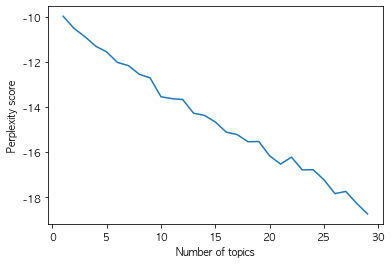

In [8]:
x = range(1,30)
plt.plot(x, perplexity_values)
plt.xlabel("Number of topics")
plt.ylabel("Perplexity score")
plt.show()

In [9]:
# 유사도: 높을수록 좋음.
# 정말 오래걸림...ㅎㅎ 

from gensim.models.ldamodel import LdaModel 
from gensim.models.callbacks import CoherenceMetric 
from gensim import corpora 
from gensim.models.callbacks import PerplexityMetric 
import logging 
from gensim.models.coherencemodel import CoherenceModel

preprocessed_docs = [' '.join(doc) for doc in data1['Mecab_token']]

coherence_values = []
for i in range(1,30):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word = id2word)
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=data1.Mecab_token.values.tolist(), dictionary=id2word,topn=10) #상위 10개의 단어들을 이용하여 유사도를 알아본다.
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

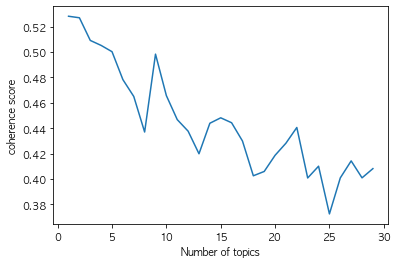

In [10]:
x = range(1,30)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("coherence score")
plt.show()

# LDA 토픽 개수 정하기
- 위 그래프를 바탕으로 적정한 토픽 개수 정하기

In [21]:
# 위 그래프를 바탕으로 임의의 K 선정
num_topics=13

In [22]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics,per_word_topics=True, eval_every = 1,
                                           id2word = id2word, passes=4, alpha=[0.01]*num_topics, eta=[0.01]*len(id2word.keys()))
for idx, topic in ldamodel.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

#모델저장
ldamodel.save('lda_1.model')

Topic: 0 Word: 0.009*"인테리어" + 0.006*"정보" + 0.006*"공유" + 0.006*"이쁘" + 0.006*"예쁘" + 0.006*"거실" + 0.005*"가입" + 0.005*"신혼" + 0.005*"감사" + 0.005*"느낌"
Topic: 1 Word: 0.007*"생각" + 0.006*"인테리어" + 0.005*"사진" + 0.005*"사람" + 0.005*"느낌" + 0.004*"입주" + 0.004*"신축" + 0.004*"거실" + 0.004*"요즘" + 0.004*"보이"
Topic: 2 Word: 0.010*"신혼집" + 0.010*"축하" + 0.009*"신혼" + 0.009*"꾸미" + 0.009*"입주" + 0.008*"보이" + 0.008*"행복" + 0.007*"구하" + 0.007*"이쁘" + 0.007*"인테리어"
Topic: 3 Word: 0.006*"노을" + 0.006*"인테리어" + 0.005*"신혼집" + 0.005*"후기" + 0.005*"청소" + 0.005*"입주" + 0.005*"사진" + 0.005*"예쁘" + 0.005*"가까워" + 0.005*"경치"
Topic: 4 Word: 0.006*"인테리어" + 0.005*"예쁘" + 0.005*"이쁘" + 0.005*"사진" + 0.004*"가구" + 0.004*"주방" + 0.004*"꾸미" + 0.004*"엄청" + 0.004*"생각" + 0.004*"느낌"
Topic: 5 Word: 0.009*"분위기" + 0.009*"인테리어" + 0.009*"예쁘" + 0.009*"느낌" + 0.009*"이쁘" + 0.008*"거실" + 0.007*"보이" + 0.007*"엄청" + 0.007*"꾸미" + 0.007*"신혼집"
Topic: 6 Word: 0.021*"로봇" + 0.021*"청소기" + 0.007*"정보" + 0.006*"지원" + 0.006*"추천" + 0.006*"아래" + 0.006*"집사" + 0.006*"드리" + 0.005

In [34]:
#저장된 모델 불러오기
# import gensim
# from gensim.models.ldamodel import LdaModel 
# ldamodel = gensim.models.ldamodel.LdaModel.load("lda.model")

In [23]:
import pandas as pd

topic_dfs = []

for i in range(num_topics):
    words = ldamodel.show_topic(i, topn=30)
    topic_words = [(word, prob) for word, prob in words]  # Separate word and probability

    df = pd.DataFrame(topic_words, columns=[f'topic{i}_word', f'topic{i}_prob'])
    topic_dfs.append(df)


empty=[]
for n in range(len(topic_dfs)):
    topic_df = topic_dfs[n]
    empty.append(topic_df)

final_lda=pd.concat(empty, axis=1)
final_lda.to_csv('word_prob_new_cluster5_인테리어_13.csv', encoding='utf-8-sig')
final_lda


,topic0_word,topic0_prob,topic1_word,topic1_prob,topic2_word,topic2_prob,topic3_word,topic3_prob,topic4_word,topic4_prob,...,topic8_word,topic8_prob,topic9_word,topic9_prob,topic10_word,topic10_prob,topic11_word,topic11_prob,topic12_word,topic12_prob
0,인테리어,0.009163,생각,0.006966,신혼집,0.010160,노을,0.006430,인테리어,0.005625,...,인테리어,0.009869,추천,0.017071,테라스,0.038582,인테리어,0.006283,신혼집,0.008622
1,정보,0.006444,인테리어,0.006255,축하,0.010052,인테리어,0.005699,예쁘,0.005284,...,센스,0.007161,청정기,0.014890,레몬,0.032608,사진,0.005681,축하,0.008504
2,공유,0.005825,사진,0.005214,신혼,0.009013,신혼집,0.005397,이쁘,0.004814,...,보이,0.006858,공기,0.014109,반갑,0.022768,생각,0.005520,행복,0.008336
3,이쁘,0.005753,사람,0.004831,꾸미,0.008730,후기,0.005352,사진,0.004792,...,감사,0.006673,렌탈,0.008201,인테리어,0.020293,고민,0.005435,신혼,0.007929
4,예쁘,0.005640,느낌,0.004627,입주,0.008534,청소,0.005333,가구,0.004461,...,예쁘,0.006603,쪽지,0.008174,가구,0.015379,가능,0.005390,예쁘,0.007906
5,거실,0.005578,입주,0.004194,보이,0.008436,입주,0.005202,주방,0.004244,...,사진,0.006432,사용,0.007682,장난감,0.014905,사용,0.005326,입주,0.007382
6,가입,0.005444,신축,0.004111,행복,0.007994,사진,0.005043,꾸미,0.004239,...,혹시,0.006049,제품,0.007358,배치,0.014123,감사,0.005299,이쁘,0.007312
7,신혼,0.005088,거실,0.003907,구하,0.007478,예쁘,0.004851,엄청,0.004192,...,엄청,0.005713,고민,0.007258,책상,0.013822,디자인,0.004554,보이,0.006993
8,감사,0.005071,요즘,0.003874,이쁘,0.007455,가까워,0.004691,생각,0.004149,...,감각,0.005549,정수기,0.007126,아이,0.013448,가구,0.004525,꾸미,0.006914
9,느낌,0.004755,보이,0.003744,인테리어,0.007304,경치,0.004542,느낌,0.004115,...,이쁘,0.005540,정보,0.007017,인사,0.010283,공간,0.004504,엄청,0.006656


# 시각화

In [28]:
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

vis = gensimvis.prepare(topic_model=ldamodel, corpus=corpus, dictionary=id2word)

#시각화 저장
pyLDAvis.save_html(vis, 'new_cluster5_인테리어_13_graph.html')
pyLDAvis.display(vis)

/Users/heojiyeon/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/heojiyeon/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/heojiyeon/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/heojiyeon/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/heojiyeon/opt/anac

# Relevance 적용한 topic 단어 추출 (참고용)
- 위에서 돌린 키워드의 특징이 뚜렷하지 않을때 Relevance score를 적용합니다
- 보통 0.6을 적정한 수치로 적용
- (김은회, & 서유화. (2020). 토픽 레이블링을 위한 토픽 키워드 산출 방법. (사) 디지털산업정보학회 논문지, 16(3), 25-36.)

In [25]:
#relevace score 적용한 topic 모델링 단어
all_topics = {}
lambd = 0.6  # Adjust this accordingly
for i in range(1,num_topics+1): 
    topic = vis.topic_info[vis.topic_info\
            .Category == 'Topic'+str(i)]
    topic['relevance'] = topic['loglift']*(1-lambd)\
                         +topic['logprob']*lambd
    #display(topic)
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:10].values #상위 10개 단어 보여주기
    #all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).relevance[:10].values

relevace_topic=pd.DataFrame(all_topics)
relevace_topic.to_csv('relevace_new_cluster5_인테리어_13.csv', encoding='utf-8-sig')
relevace_topic

/var/folders/sf/g5ffdfm57wv22zjhcdsjt1rm0000gn/T/ipykernel_30608/1353053710.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic['relevance'] = topic['loglift']*(1-lambd)\
/var/folders/sf/g5ffdfm57wv22zjhcdsjt1rm0000gn/T/ipykernel_30608/1353053710.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic['relevance'] = topic['loglift']*(1-lambd)\
/var/folders/sf/g5ffdfm57wv22zjhcdsjt1rm0000gn/T/ipykernel_30608/1353053710.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13
0,축하,분위기,축하,소음,책상,아치형,동탄,죽이,가입,청정기,노을,레몬,로봇
1,행복,스타일,구하,가능,배치,감각,탈퇴,상견례,조사,렌탈,가까워,테라스,청소기
2,신혼집,느낌,신혼집,층간,가구,센스,사람,방비,때리,공기,주공,반갑,보락
3,신혼,정보,신혼,사용,책장,정석,홍보,오오,요구,추천,경치,장난감,레이더스
4,입주,예쁘,입주,타워,옷장,환골탈태,지출,가까워,경우_보삭,정수기,놀러,인사,모래
5,생활,집들이,꾸미,디자인,고민,인테리어,무려,첫입,강퇴,혜택,편의,세이지,에코
6,예쁘,화이트,고생,추천,침대,셀프,뚤려,전경,발생_막상,코웨이,쭈욱,책상,메트
7,결혼,이쁘,행복,시공,인테리어,감사,제집,사택,무통,프라이어,흐엉,활동,비데
8,가전,조명,보이,매트,이케아,혹시,생각,식이,커뮤니티,오븐,탁트인,아이,제트
9,이쁘,거실,후기,주문,조언,근접,업체_지속,척척,판단,쪽지,이모님,책장,스몰


# 토픽 문장 할당 gamma 수치로 결정

In [26]:
sent_topics_df = pd.DataFrame()

# Get main topic in each document
for i, row_list in enumerate(ldamodel[corpus]):
    row = row_list[0] if ldamodel.per_word_topics else row_list # 각 문서에 대한 토픽할당 확률값           
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    
    # Get the Dominant topic, Perc Contribution and Keywords for each document
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:  # => dominant topic
            wp = ldamodel.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords, row]), ignore_index=True)
        else:
            break
            
sent_topics_df.columns = ['topic', 'topic_weight', 'Topic_Keywords', 'topic_all_weight']
sen1=sent_topics_df.copy()
contents = pd.DataFrame({'Content':data1['review']})
sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
sent_topics_df1=sent_topics_df.loc[:,['topic','topic_weight','Topic_Keywords','Content','topic_all_weight']]


#대표문장 뽑기 (참고용)
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = sent_topics_df1.groupby('topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['topic_weight'], ascending=False).head(1)], 
                                            axis=0)

sent_topics_sorteddf_mallet=sent_topics_sorteddf_mallet.iloc[:, 0:4]

# csv저장
sent_topics_sorteddf_mallet.to_csv('new_cluster5_인테리어_13_토픽별_대표문장.csv', encoding='utf-8-sig') # 각 토픽별 대표문장입니다. 토픽 정할떄 참고해주세용!
sent_topics_sorteddf_mallet

/var/folders/sf/g5ffdfm57wv22zjhcdsjt1rm0000gn/T/ipykernel_30608/2845854987.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords, row]), ignore_index=True)
/var/folders/sf/g5ffdfm57wv22zjhcdsjt1rm0000gn/T/ipykernel_30608/2845854987.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords, row]), ignore_index=True)


,topic,topic_weight,Topic_Keywords,Content
643,0,0.9986,"인테리어, 정보, 공유, 이쁘, 예쁘, 거실, 가입, 신혼, 감사, 느낌",드디어 침대를 배송 받았어요 가전업체에서 신랑신부인척 저렴한 견적을 올리고 막상 방문하면 해당 견적이 불가능하거나 상조가입 등 무리한 조건을 요구하는 경우가 자주 발생하고 ...
1060,1,0.9988,"생각, 인테리어, 사진, 사람, 느낌, 입주, 신축, 거실, 요즘, 보이",익게 틈 타 랜선집들이 전에 한 번 올렸었는데 이사한지 한 달 넘고 거의 정리 다 돼서 함 더 올림 울집 평 평면도야 이거 보고 따라와 거실 가족들 집들이 때 할머니 이 벽...
429,2,0.9992,"신혼집, 축하, 신혼, 꾸미, 입주, 보이, 행복, 구하, 이쁘, 인테리어",제 예랑이는 군인입니다 유효기간이 정해져있는 직업군인이요 전역 전까지 살 수 있는 집 어차피 나와야 하는 집 년계약 전세같은 군인집입니다 신혼집이라고 하기엔 저는 제 집에서...
1220,3,0.9982,"노을, 인테리어, 신혼집, 후기, 청소, 입주, 사진, 예쁘, 가까워, 경치",신혼집 입주후기입니다 늦은 신혼집 입주후기입니다 저희는 년 넘은 부천에 구축아파트에 전세로 입주했는데요 결혼식을 치루고 신혼여행을 다녀와서 바로 입주했습니다 둘다 큰 짐은 ...
1433,4,0.9984,"인테리어, 예쁘, 이쁘, 사진, 가구, 주방, 꾸미, 엄청, 생각, 느낌",살고싶은 전원주택 고급스러운 빌트인 주방 화이트 맞춤가구 자연속에서 살고 싶은 로망을 이루어줄 전원주택 창을 액자삼아 자연과 함께 힐링공간이 되는 곳을 집을 짓는다면 내가 ...
877,5,0.9992,"분위기, 인테리어, 예쁘, 느낌, 이쁘, 거실, 보이, 엄청, 꾸미, 신혼집",결혼하고 극집순이형이 되어버린 우리집후기 결혼하기전에는 진 무슨 집안에 있으면 두드러기 나는 애인것처럼 집밖으로 나도느라 바빴었는데옄 매주 주말엔 풀 약속 결혼준비하면서 집...
1874,6,0.9964,"로봇, 청소기, 정보, 지원, 추천, 아래, 집사, 드리, 모래, 기능",코웨이 정수기 비데 렌탈하려는데요 정수기는 노블 빌트인 냉정수만 온수 비데는 가장 저렴한 모델로 렌탈하려고 해요 지원 많은 영사님 소개 카드 만들지 않고 현금 지원 많이 해...
1760,7,0.9987,"가구, 배치, 인테리어, 책상, 고민, 침대, 생각, 공간, 사진, 이사",살까말까 신혼집 인테리어 가전 가구 소품 위시리스트 소키포키 신혼집 쿠키집 에는 진짜 당장 몸만 가서 살아도 될 만큼 다 있지만 그래도 사야 할 것들을 생각해봤다 평 방 화...
2000,8,0.9987,"인테리어, 센스, 보이, 감사, 예쁘, 사진, 혹시, 엄청, 감각, 이쁘",최소 시공과 스타일링으로 꾸민 평대 아파트 인테리어 집을 사무실과 스튜디오 창고 등으로 겸해서 쓰기 위해 올해 초에 지금 집으로 이사를 왔어요 전셋집이기에 최소한의 시공만 ...
86,9,0.9988,"추천, 청정기, 공기, 렌탈, 쪽지, 사용, 제품, 고민, 정수기, 정보",개월도 사용안한 무빙세일 아이가 스튜디오에서 혼자사용한지 개월도 안 된 깨끗한 물건들입니다 일정이 바뀌어 한국으로 들어가게되어 무빙세일합니다 개별판매도 가능합니다 장소는 다...


In [27]:
sent_topics_df1['tokenizing']=data.review_token

#csv 저장
sent_topics_df1.to_csv('[최종]new_cluster5_인테리어_13.csv', encoding='utf-8-sig')
sent_topics_df1

,topic,topic_weight,Topic_Keywords,Content,topic_all_weight,tokenizing
0,9,0.2871,"추천, 청정기, 공기, 렌탈, 쪽지, 사용, 제품, 고민, 정수기, 정보",코웨이 렌탈 관련 문의기존에 코웨이에서 공기청정기랑 비데를 이용중이었는데 새로 신혼집 입주하면서 매트리스랑 정수기를 추가로 이용하려구요 이 경우에 공기청정기랑 비데 가입할 ...,"[(9, 0.2871007), (12, 0.24635571), (11, 0.23469582), (10, 0.17570148), (6, 0.054547094)]","['프로', '계시', '받다', '네넵', '코웨이', '신혼집', '사원', '추천', '싶다', '댓글', '더', '안해', '줄다', '공짜', '영업', '낫',..."
1,10,0.9937,"테라스, 레몬, 반갑, 인테리어, 가구, 장난감, 배치, 책상, 아이, 인사",장난감수납장 어떤거 쓰세요 장난감 수납할 수 있는 정리함 같은거 보고 있는데 뭐가 좀 깔끔하면서 튼튼한가요 세이지폴꺼 추천드려요 튼튼하고 테이블도 결합되어 있어서 가성비 좋...,"[(10, 0.9937266)]","['세이지', '되어다', '가성', '장도', '보고', '디자인', '추천', '들이다', '이번', '사용', '수납', '함', '드리다', '등', '가능하다', ..."
2,11,0.9270,"인테리어, 사진, 생각, 고민, 가능, 사용, 감사, 디자인, 가구, 공간",리뷰 lg 에어로타워 공기청정기 온풍 퓨리케어 오브제 경훈 lg 퓨리케어 오브제컬렉션 에어로 타워 공기 청정기 온풍 올겨울은 유난히 춥다 하죠 겨울에 사용할 온풍기를 알아보...,"[(11, 0.9270427), (4, 0.04771458), (9, 0.024744812)]","['춥다', '끼우다', '일반인', '맨', '추천', '원', '꼽', '그대로', '전원', '필터', '부분', '이르다', '기능', '끼다', '문제', '물',..."
3,1,0.6421,"생각, 인테리어, 사진, 사람, 느낌, 입주, 신축, 거실, 요즘, 보이",자리차지 별로 안하는 예쁜 공기청정기 없나요공기청정기 물론 성능이 제일이지요 다만 성능 좋다고 으리으리한 거 쓴적 있는데 생각보다 사이즈 넘 크고 지나다닐때마다 거슬렸어요 ...,"[(1, 0.6420919), (9, 0.35509148)]","['딕', '네', '요전', '카드', '평형', '유', '보통', '귀엽다', '추천', '별로', '적', '두기', '자리', '대다', '부유', '쓰다', '사..."
4,5,0.5331,"분위기, 인테리어, 예쁘, 느낌, 이쁘, 거실, 보이, 엄청, 꾸미, 신혼집",놀이방 아이방 공간재배치 정리수납 제가 전직 보육교사였기에 놀이방 아이방 정리수납에 자신이 있답니다 오늘은 아이방 놀이방 정리수납한 사진을 올려봅니다 참고해서 공간 꾸며보셔요,"[(5, 0.53307056), (10, 0.45849884)]","['수납', '보다', '방', '참고', '아이방', '교사', '배치', '꾸미다', '전직', '오늘', '공간', '놀이', '보육', '올리다', '재', '사진'..."
...,...,...,...,...,...,...
3270,10,0.9617,"테라스, 레몬, 반갑, 인테리어, 가구, 장난감, 배치, 책상, 아이, 인사",새로 가입했어요 반갑습니당 반갑습니다 반갑습니다,"[(10, 0.96166)]","['습', '가입', '니당다', '새롭다', '반갑다']"
3271,10,0.9709,"테라스, 레몬, 반갑, 인테리어, 가구, 장난감, 배치, 책상, 아이, 인사",반갑습니다 레몬테라스 가입했어요 잘부탁드립니다 반갑습니다 반갑습니다,"[(10, 0.9709441)]","['부탁드리다', '테라스', '반갑다', '레몬', '가입']"
3272,10,0.9709,"테라스, 레몬, 반갑, 인테리어, 가구, 장난감, 배치, 책상, 아이, 인사",반갑습니다 드디어 레몬테라스에 왔네요 반갑습니다 반갑습니다아 반갑습니다 안녕하세욤 반가워용 반갑습니다 반갑습니당 반갑습니다 반가워요,"[(10, 0.970944)]","['테라스', '습', '반갑다', '니당다', '욤', '안녕하다', '레몬']"
3273,10,0.9437,"테라스, 레몬, 반갑, 인테리어, 가구, 장난감, 배치, 책상, 아이, 인사",반가워요 레몬테라스에 가입했어요 반갑습니다 반가워용 반가워요 반가워요 반갑습니다 반가워요 반가워요 반가워요 안녕하세용 반 반갑습니다 반가워요,"[(10, 0.9436618)]","['테라스', '반', '반갑다', '안녕하다', '레몬', '가입']"


In [ ]:
#0.125 이하일 경우 삭제시키는데... --> 데이터가 부족하니 다 살리는건?
# total.loc[total['Perc_Contribution']<=0.125]